In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Music Recommendation System - Spotify
In this notebook we are concerned about developing a simple music recommendation method, with the aid of a dataset of 1.2 M Spotify songs, including track features such as valence, energy, and acousticness. The method here developed is, of course, limited to songs on the dataset, such that it can only returns as recommendations musics therein contained.

Spotify recommendation system goes through several processing layers of data, from collaborative filtering with its millions of users to embeddings and neural networks, until it specifies its recommendations to the user. In our case, we will develop a framework of content filtering, as we do not have access to Spotify's user database, that would occur in only one of such layers.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white')

## Get Data
Even tough the dataset is large, we can still read it with pandas. This simplifies the code and analysis without compromising the execution time.

In [ ]:
file_path = '/content/drive/MyDrive/PythonProjects/MusicRecommendation/tracks_features.csv'

df = pd.read_csv(file_path)
df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


## Data Cleaning
We observe no duplicated values and very few missing values, which will be dropped.

In [ ]:
print(f'Dataframe length: {len(df)}')
print(f'Dataframe length without duplicates: {len(df.drop_duplicates(subset="id"))}')

print('\nNull values:')
print(df.isnull().sum())

df = df.dropna()

Dataframe length: 1204025
Dataframe length without duplicates: 1204025

Null values:
id                   0
name                 3
album               11
album_id             0
artists              0
artist_ids           0
track_number         0
disc_number          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
year                 0
release_date         0
dtype: int64


Here, we drop unnecessary columns, assign the correct data types to each remaining variable, and perform minor transformations.

In [ ]:
drop = [
    'album', 'album_id',
    'artist_ids', 'track_number',
    'disc_number', 'release_date'
]

df = df.drop(drop, axis=1)

df['key'] = df['key'].astype(str)
df['time_signature'] = df['time_signature'].astype(int).astype(str)
df['mode'] = df['mode'].astype(int)
df['explicit'] = df['explicit'].astype(int)
df['year'] = df['year'].astype(str)

# eliminating the list format [''] from songs with one artists only
df['artists'] = df['artists'].str[2:-2]

# renaming the mode column to better clarify its meaning
# mode: 1 if is major, 0 otherwise, then, we change it to is_major
df = df.rename(
    columns={'mode': 'is_major'}
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1204012 entries, 0 to 1204024
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1204012 non-null  object 
 1   name              1204012 non-null  object 
 2   artists           1204012 non-null  object 
 3   explicit          1204012 non-null  int64  
 4   danceability      1204012 non-null  float64
 5   energy            1204012 non-null  float64
 6   key               1204012 non-null  object 
 7   loudness          1204012 non-null  float64
 8   is_major          1204012 non-null  int64  
 9   speechiness       1204012 non-null  float64
 10  acousticness      1204012 non-null  float64
 11  instrumentalness  1204012 non-null  float64
 12  liveness          1204012 non-null  float64
 13  valence           1204012 non-null  float64
 14  tempo             1204012 non-null  float64
 15  duration_ms       1204012 non-null  int64  
 16  time_

## EDA

### Music Key
Set of notes that define the main scale of the song, thus determining the root note (key) and corresponding chords, orientating the listener throughout the song. It is not expected to see any influence of this feature regarding music taste, since it is irrelevant whether the music is on G (key = 7) or A (key = 9) as it is usually defined in order to facilitate the music play and to acommodate the singer's vocal extension. In other words, the music key should be irrelevant when concerning recommendations, such that it is not a variable to be used.

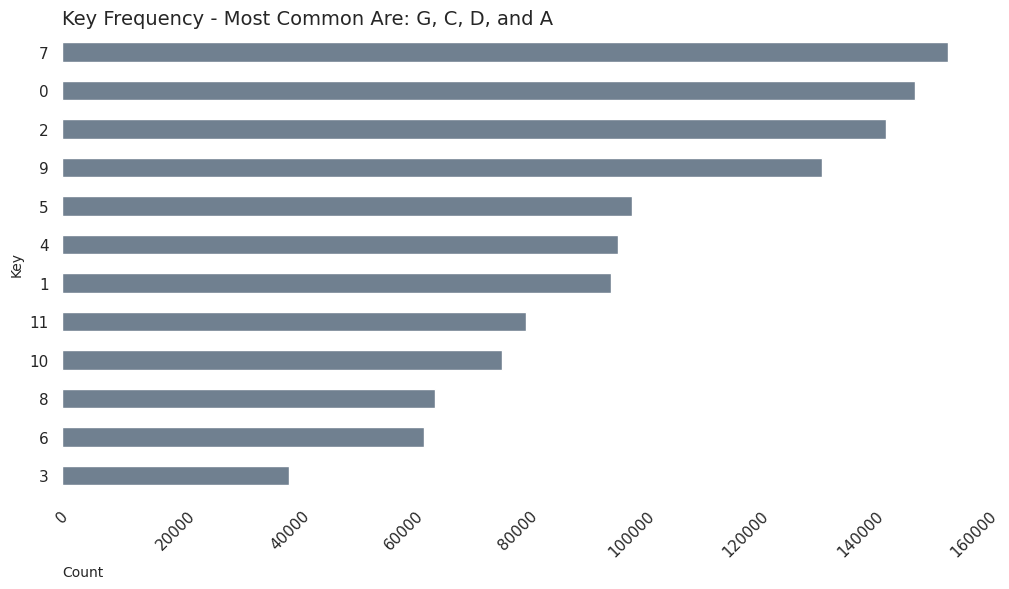

In [ ]:
plt.figure(figsize=(12, 6))
plt.box(False)
df['key'].value_counts().sort_values(ascending=True).plot(kind='barh', color='slategrey')
plt.title('Key Frequency - Most Common Are: G, C, D, and A', loc='left', fontsize=14)
plt.xlabel('Count', loc='left', fontsize=10)
plt.ylabel('Key', fontsize=10)
plt.xticks(rotation=45);

### Artists
Counting the most common artists, we see no absolute prevalence when considering the whole dataset, since the most frequent represents only 0.1%. Thus, we can think of the dataset as unbiased when concerning artists. This would be a concern if a considerable percentage (more than 5%, say) was represented by a single artist.

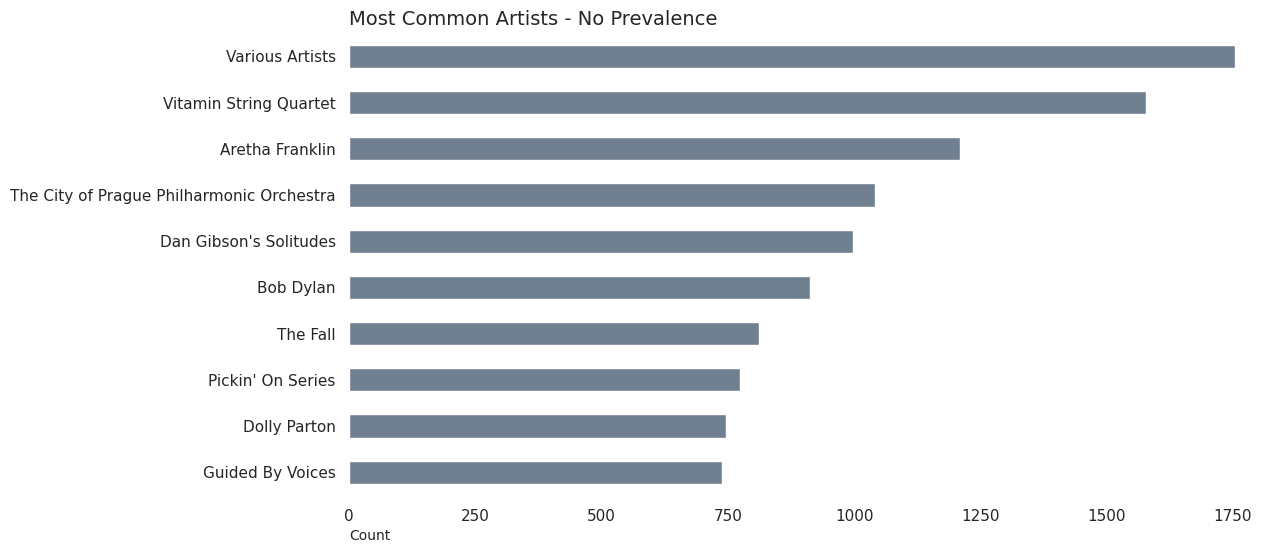

In [ ]:
s = df['artists'].value_counts().sort_values(ascending=False).copy()

plt.figure(figsize=(12, 6))
plt.box(False)
s.head(10)[::-1].plot(kind='barh', color='slategrey')
plt.title('Most Common Artists - No Prevalence', loc='left', fontsize=14)
plt.xlabel('Count', loc='left', fontsize=10)
plt.ylabel('');

### Year
Year ranges from 1900 to 2020, such that, when we consider their age (regarding the current year) and decade, we observe a higher concentration of songs from the last 20 years, since $Q_3 = 23$ (third quantile). The dataset is thus biased towards newer songs.

Also, we observe very few tracks with `year = 0`, which will be dropped, so as not to yield unrealistic results when calculating music age and decade.

In [ ]:
df = df.query('year != "0"').reset_index(drop=True)

In [ ]:
print(df['year'].min())
print(df['year'].max())

1900
2020


In [ ]:
df['music_age'] = 2025 - df['year'].astype(int)
df['decade'] = (df['year'].astype(int) - df['year'].astype(int).min()) // 10 + 1

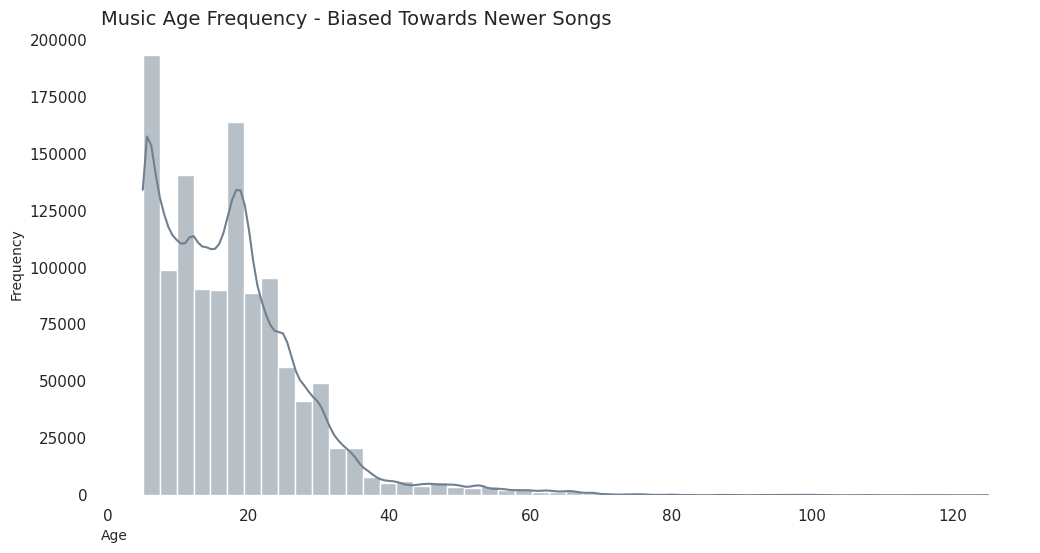

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='music_age',
    bins=50,
    kde=True,
    color='slategrey'
)
plt.box(False)
plt.title('Music Age Frequency - Biased Towards Newer Songs', loc='left', fontsize=14)
plt.ylabel('Frequency', fontsize=10)
plt.xlabel('Age', loc='left', fontsize=10);

In [ ]:
df['music_age'].describe()

,music_age
count,1.204002e+06
mean,1.765562e+01
std,1.062887e+01
min,5.000000e+00
25%,1.000000e+01
50%,1.600000e+01
75%,2.300000e+01
max,1.250000e+02


When looking at decade, we consider as 0 songs written in 1900. The plot below exhibits the prevalence of newer songs, as the count of decade 11 and 12 are way higher than the others.

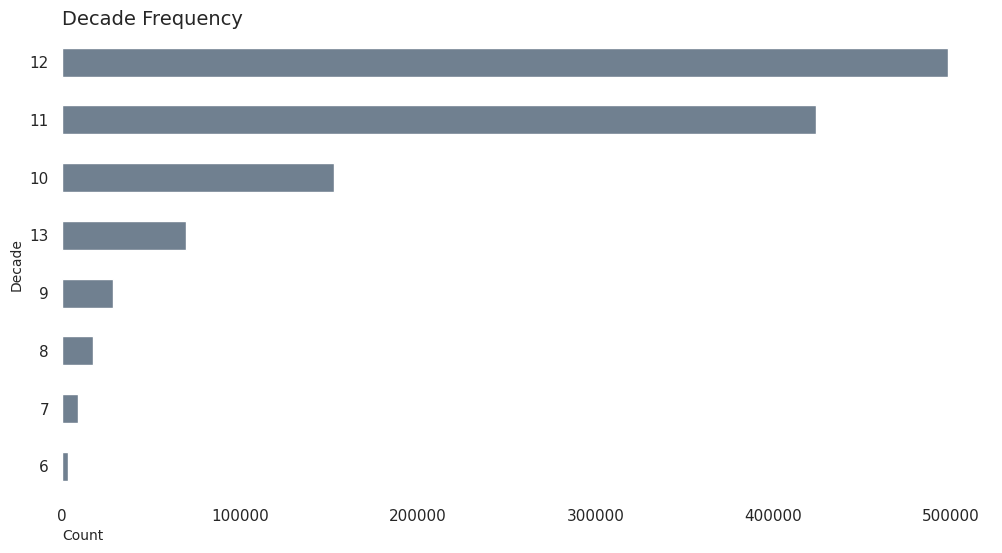

In [ ]:
s = df['decade'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.box(False)
s.head(8)[::-1].plot(kind='barh', color='slategrey')
plt.title('Decade Frequency', loc='left', fontsize=14)
plt.ylabel('Decade', fontsize=10)
plt.xlabel('Count', loc='left', fontsize=10);

More interestingly, we are able to see the evolution of some music features through time. Particularly, the rapid decrese of the acousticness feature, starting from 1950, resulting from amplified distortions and overdrive pedals, and the increase of the energy feature. Later, we confirm the strong negative correlation between them.

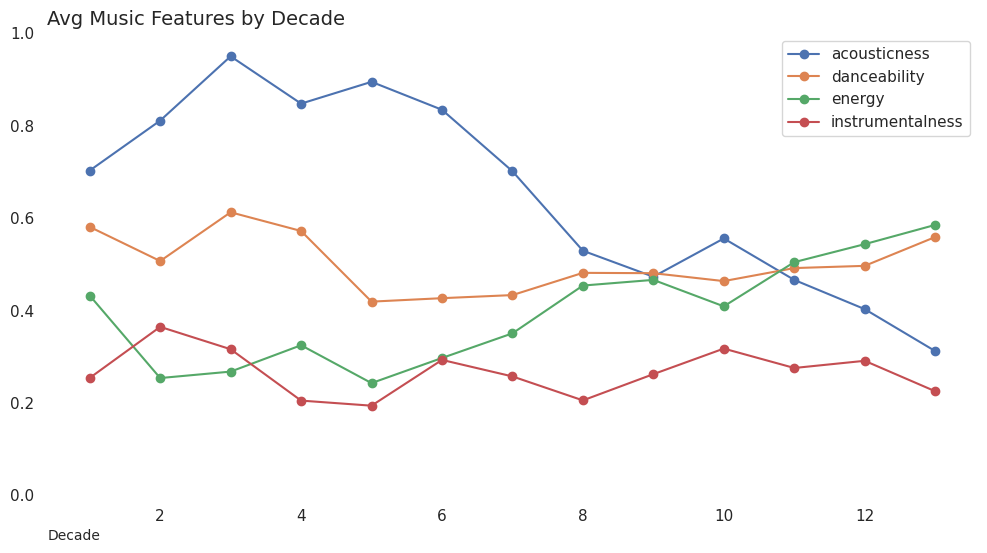

In [ ]:
aux = df[['acousticness', 'decade']].groupby('decade').mean()
aux1 = df[['danceability', 'decade']].groupby('decade').mean()
aux2 = df[['energy', 'decade']].groupby('decade').mean()
aux3 = df[['instrumentalness', 'decade']].groupby('decade').mean()

ax = aux.plot(figsize=(12, 6), marker='o')
aux1.plot(ax=ax, marker='o')
aux2.plot(ax=ax, marker='o')
aux3.plot(ax=ax, marker='o')
plt.box(False)
plt.title('Avg Music Features by Decade', loc='left', fontsize=14)
plt.ylim(0, 1)
plt.xlabel('Decade', loc='left', fontsize=10);

## Feature Engineering
Here we divide our variables into their data types to better organize our dataset.

In [ ]:
n_cols = [
    'acousticness', 'danceability', 'duration_ms',
    'energy', 'instrumentalness', 'liveness',
    'loudness', 'speechiness', 'tempo',
    'valence', 'music_age'
]

c_cols = [
    'key', 'year', 'time_signature'
]

b_cols = [
    'explicit', 'is_major',
    'time_signature_3', 'time_signature_4',
    'time_signature_other'
]

Energy has high correlation with acousticness and loudness: it will be dropped.

In [ ]:
display(df[n_cols].corr())

df = df.drop(columns=['energy'])

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,music_age
acousticness,1.000000,-0.285738,0.002511,-0.796245,0.244147,-0.115005,-0.671558,-0.082370,-0.231016,-0.268826,0.173868
danceability,-0.285738,1.000000,-0.135407,0.283014,-0.285352,-0.044323,0.378200,0.209856,0.060588,0.563437,-0.081382
duration_ms,0.002511,-0.135407,1.000000,-0.037600,0.121330,0.005907,-0.051888,-0.078868,-0.020769,-0.193190,0.010657
energy,-0.796245,0.283014,-0.037600,1.000000,-0.252140,0.213494,0.817934,0.130809,0.268225,0.399525,-0.163906
instrumentalness,0.244147,-0.285352,0.121330,-0.252140,1.000000,-0.118990,-0.393041,-0.167556,-0.071459,-0.284727,0.007271
liveness,-0.115005,-0.044323,0.005907,0.213494,-0.118990,1.000000,0.138124,0.189013,0.030144,0.062663,0.018158
loudness,-0.671558,0.378200,-0.051888,0.817934,-0.393041,0.138124,1.000000,0.062399,0.246243,0.385003,-0.195808
speechiness,-0.082370,0.209856,-0.078868,0.130809,-0.167556,0.189013,0.062399,1.000000,0.007736,0.099673,-0.066432
tempo,-0.231016,0.060588,-0.020769,0.268225,-0.071459,0.030144,0.246243,0.007736,1.000000,0.176187,-0.045072
valence,-0.268826,0.563437,-0.193190,0.399525,-0.284727,0.062663,0.385003,0.099673,0.176187,1.000000,0.059987


### Time Signature
Number of beats per measure (bar) followed by which note represents one beat as, for instance, 3/4 and 4/4 (the most common ones). This highly influentiate music danceability and its rhythmic sensation. We will divide it into three categories: 3/4, 4/4 and other, as more complex time signatures (irregular) are usually non-western music and rare in pop/rock music. In other words, it is a very distinguishing feature.

In [ ]:
df.loc[~(df['time_signature'].isin(['4', '3'])), 'time_signature'] = 'other'

Being a categorical variable represented numerically, we make use of the `OneHotEncoder` technique.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

encoded = enc.fit_transform(df[['time_signature']])
df_encoded = pd.DataFrame(encoded, columns=enc.get_feature_names_out())

df_enc = pd.concat(
    [df.drop(columns='time_signature'), df_encoded],
    axis=1
)

df_enc.head()

,id,name,artists,explicit,danceability,key,loudness,is_major,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,year,music_age,decade,time_signature_3,time_signature_4,time_signature_other
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,Rage Against The Machine,0,0.470,7,-5.399,1,0.0727,0.02610,...,0.3560,0.503,117.906,210133,1999,26,10,0.0,1.0,0.0
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,Rage Against The Machine,1,0.599,11,-5.764,1,0.1880,0.01290,...,0.1550,0.489,103.680,206200,1999,26,10,0.0,1.0,0.0
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,Rage Against The Machine,0,0.315,7,-5.424,1,0.4830,0.02340,...,0.1220,0.370,149.749,298893,1999,26,10,0.0,1.0,0.0
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,Rage Against The Machine,1,0.440,11,-5.830,0,0.2370,0.16300,...,0.1210,0.574,96.752,213640,1999,26,10,0.0,1.0,0.0
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,Rage Against The Machine,0,0.426,2,-6.729,1,0.0701,0.00162,...,0.0789,0.539,127.059,205600,1999,26,10,0.0,1.0,0.0


If we compute the mean danceability value for `time_signature_4`, we observe a higher value for `time_signature_4 = 1`, which can also be seen from its distribution.

In [ ]:
df_enc.groupby('time_signature_4')['danceability'].mean()

,danceability
time_signature_4,
0.0,0.381892
1.0,0.517269


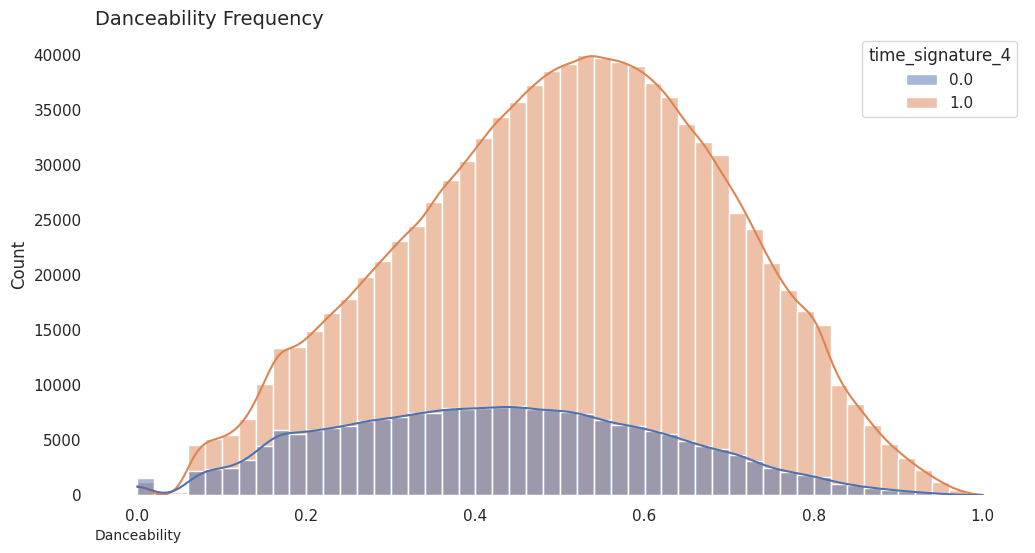

In [ ]:
c = 'danceability'

plt.figure(figsize=(12, 6))
plt.box(False)
sns.histplot(
    data=df_enc,
    x=c,
    bins=50,
    kde=True,
    hue='time_signature_4'
)
plt.title(f'{c.title()} Frequency', loc='left', fontsize=14)
plt.xlabel(c.title(), loc='left', fontsize=10);

## Modeling - PCA
As we have a large dataset with several columns, it may be convenient to reduce the number of variables so as to reduce the computational cost. We can achieve this with the Principal Components Analysis techinique, which calculates a new set of linearly independent variables $X'$ from the original set $X$. Its great advantage, however, is to find an optimal number $n'$, for which $n' < n$, being $n$ the original number of variables, such that we maintain the maximum variance as possible. This can be accomplished by evaluating the amount of explicability gained at each variable added and deciding a cut-off point. This technique is, however, affected by the features scale, so that we need to standardize them first.

In our case, for instance, we have $n = 15$ with 100% explicability. By looking at the graph below, we find 90% of explicability with $n' = 10$ components, hence reducing by 1/3 the number of features and simplifying the subsequent calculations.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_enc.copy()
df_scaled[n_cols] = scaler.fit_transform(df_enc[n_cols])

Testing n=1...
Testing n=2...
Testing n=3...
Testing n=4...
Testing n=5...
Testing n=6...
Testing n=7...
Testing n=8...
Testing n=9...
Testing n=10...
Testing n=11...
Testing n=12...
Testing n=13...
Testing n=14...
Testing n=15...


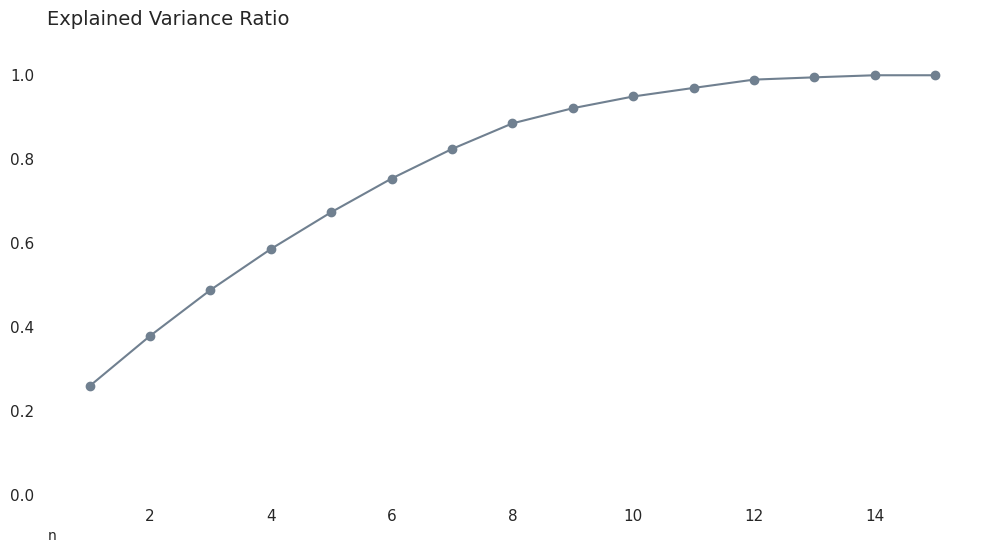

In [ ]:
n_cols_ = [c for c in n_cols if c != 'energy']
features = n_cols_ + b_cols

X_scaled = df_scaled[features].copy()
X_np = X_scaled.to_numpy()

sums = []
N = len(n_cols_ + b_cols)

for n in range(1, N + 1):
    print(f'Testing n={n}...')
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_np)
    sums.append(np.sum(pca.explained_variance_ratio_))


plt.figure(figsize=(12, 6))
plt.box(False)
plt.plot(range(1, N + 1), sums, marker='o', color='slategrey')
plt.ylim(0, 1.1)
plt.title('Explained Variance Ratio', loc='left', fontsize=14)
plt.xlabel('n', loc='left', fontsize=10);

## Cosine Similarity
Our recommendation system will be based upon the cosine similarity metric. Given two vectors ${\bf a}$ and ${\bf b}$, their cosine similarity is defined via $$\cos\theta = \frac{{\bf a} \cdot {\bf b}}{||{\bf a}|| \ ||{\bf b}||},$$ where $\theta$ is the angle between them, such that it ranges from -1 to 1, with 1 being perfectly aligned and -1 being perfectly opposite. It emphasizes their direction and orientation rather than their magnitude. Considering that we have features with different scales, this method is preferable over clustering with KMeans and Euclidean distances. In fact, given the relation $$||{\bf a} - {\bf b}||^2 = 2(1 - \cos\theta),$$ if ${\bf a}$ and ${\bf b}$ are unit vectors, we see that minimizing the Euclidean distance refers to maximizing the cosine. This is interesting since clustering with KMeans is more computationally expensive than simply calculating the vectors orientations.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
n_opt = 10
pca = PCA(n_components=n_opt, random_state=1)
X_pca = pca.fit_transform(X_scaled)

df_pca = df[['id']].copy()
for i in range(n_opt):
    df_pca[f'pca_{i}'] = X_pca[:, i]

,id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
46970,40rWYHjkAyzpWkRsYXBAMW,2.070508,1.849794,2.586473,2.549326,-1.1295,-0.077754,1.148097,1.810214,0.161035,-0.429544


From the vectors components, we choose a test song (Billie Jean - Michael Jackson) to compute its 10 closest songs (recommendations).

In [ ]:
# test song - Billie Jean
id = '5FEni1BSfVy7VC2HjVbqlE'
v = df_pca.query('id == @id').drop(columns='id').to_numpy()

vectors = df_pca.drop(columns='id').to_numpy()

sims = cosine_similarity(v, vectors)[0]

df_pca['sim'] = sims

top = 11
recommendations = df_pca.sort_values(by='sim', ascending=False).head(top)
recommendations

,id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,sim
1142979,5FEni1BSfVy7VC2HjVbqlE,2.186696,-0.266580,-1.236065,-0.794767,1.077154,0.615877,0.369688,0.316625,0.504937,-0.836358,1.000000
1044063,1AAvGHsyB1WcKPSxpTpkbk,1.994688,-0.185760,-1.072300,-0.585632,0.945340,0.426993,0.025593,0.240658,0.619027,-0.859754,0.988934
991371,3hE65yMbX5XKzhplzGX3OX,2.088678,-0.211209,-1.131597,-0.568939,1.166866,0.576039,0.208237,0.590371,0.278034,-0.902298,0.987762
883948,4xI3JHyhMVblf0vFY7sDLM,2.112220,0.012309,-1.099372,-0.572781,1.182331,0.411401,0.145143,0.344193,0.622690,-0.750703,0.986521
467434,0XTE0T8fcUPPrl6Y52mSs3,1.855190,-0.241438,-0.955836,-0.501001,0.684164,0.252571,0.187464,0.198301,0.228936,-0.548830,0.986064
717558,7c7G1ekVGrhZlAtE2WF6Fe,2.493023,-0.453039,-1.418467,-0.790832,0.991698,0.364599,0.312515,0.514224,0.228393,-0.728586,0.984750
862043,5hTYWGkixj4GYB8mgDeXZU,2.373656,-0.570356,-1.433251,-0.702691,0.841099,0.719218,0.262331,0.375906,0.206221,-0.950166,0.984158
877988,5mWfv0zvugz9FdLaZrMoiD,2.478339,-0.077865,-1.343335,-0.902083,1.173777,0.548563,0.284028,0.697316,0.225594,-0.688299,0.984119
234982,3LlpVE40aOa07hJB45n0WC,2.174664,-0.251775,-1.075300,-0.644531,0.751089,0.174532,0.305237,0.392264,0.419457,-0.799359,0.983576
541400,1Mu5GiW3if9MSAp9tpENdd,2.293056,0.057048,-1.324309,-0.857840,0.967428,0.439711,0.038651,0.414867,0.606362,-0.660884,0.983106


In [ ]:
recommendations[['id']].merge(df[['id', 'name', 'artists']], on='id')

,id,name,artists
0,5FEni1BSfVy7VC2HjVbqlE,Billie Jean,Michael Jackson
1,1AAvGHsyB1WcKPSxpTpkbk,Girls Were Made to Love,Surface
2,3hE65yMbX5XKzhplzGX3OX,Too Tough,Angela Bofill
3,4xI3JHyhMVblf0vFY7sDLM,Reverse Skydiving (feat. Anabel Englund),"Hot Natured', 'Anabel Englund"
4,0XTE0T8fcUPPrl6Y52mSs3,Full Circle,"Kipori ""Baby Wolf"" Woods"
5,7c7G1ekVGrhZlAtE2WF6Fe,Sweet Sensation,Yvonne Curtis
6,5hTYWGkixj4GYB8mgDeXZU,Hey Girl (I Love the Way You Dance),The Chi-Lites
7,5mWfv0zvugz9FdLaZrMoiD,In Every Way (Classic Mix),Kamar
8,3LlpVE40aOa07hJB45n0WC,The Fall,Bootleggers
9,1Mu5GiW3if9MSAp9tpENdd,Meneo Insuperable: Menea Tu Chapa / Te Ves Buena,Miguel Angel Tzul y su Marimba Orquesta
